In [8]:
import argparse
from random import seed
from mylib.utils import fix_seed
from mylib.data.data_loader import load_ucidata

import numpy as np
from run_dnl import run_dnl
import tools
import pandas as pd
from kmeans import run_kmeans
import os
import argparse
import scipy
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from kmeans import run_kmeans
# --- parsing and configuration --- #
parser = argparse.ArgumentParser(
    description="PyTorch implementation of VAE")
parser.add_argument('--batch_size', type=int, default=16,
                    help='batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=10,
                    help='number of epochs to train (default: 20)')
parser.add_argument('--z_dim', type=int, default=25,
                    help='dimension of hidden variable Z (default: 10)')
parser.add_argument('--num_hidden_layers', type=int, default=2,
                    help='num hidden_layers (default: 0)')
parser.add_argument('--flip_rate_fixed', type=float,
                    help='fixed flip rates.', default=0.4)
parser.add_argument('--train_frac', default=1.0, type=float,
                    help='training sample size fraction')
parser.add_argument('--noise_type', type=str, default='sym')
parser.add_argument('--trainval_split',  default=0.8, type=float,
                    help='training set ratio')
parser.add_argument('--seed', default=1, type=int,
                    help='seed for initializing training')
parser.add_argument('--dataset', default="krkp", type=str,
                    help='db')
parser.add_argument('--select_ratio', default=0, type=float,
                    help='confidence example selection ratio')
parser.add_argument('--pretrained', default=0, type=int,
                    help='using pretrained model or not')


# added by yz:
parser.add_argument('--pca_k', type=int, default=5,
                    help='PCA dimension (default: 5)')
parser.add_argument('--sample_size', type=int, default=20,
                    help = 'randomly select samples for analysis')                  
parser.add_argument('--near_percentage', type=float, default=0.1,
                    help='percentage nearby in terms of L2 norm')

arch_dict = {"FashionMNIST":"resnet18","cifar10":"resnet18","cifar100":"resnet34","mnist":"Lenet","balancescale":"NaiveNet","krkp":"NaiveNet","splice":"NaiveNet","yxguassian":"NaiveNet"}

# Args

In [61]:
# load dataset
args = parser.parse_args(args=['--dataset', 'yxguassian'])
base_dir = "./"+args.dataset+"/"+args.noise_type+str(args.flip_rate_fixed)+"/"+str(args.seed)+"/"
print(args)

if args.seed is not None:
    fix_seed(args.seed)
train_val_loader, train_loader, val_loader, est_loader, test_loader = load_ucidata(
    dataset = args.dataset,  
    noise_type = args.noise_type,
    random_state = args.seed, 
    batch_size = args.batch_size, 
    add_noise = True, 
    flip_rate_fixed = args.flip_rate_fixed, 
    trainval_split = args.trainval_split,
    train_frac = args.train_frac,
    augment=False
)
test_dataset = test_loader.dataset
val_dataset = val_loader.dataset

train_dataset = train_loader.dataset
print("done")

Namespace(batch_size=16, dataset='yxguassian', epochs=10, flip_rate_fixed=0.4, near_percentage=0.1, noise_type='sym', num_hidden_layers=2, pca_k=5, pretrained=0, sample_size=20, seed=1, select_ratio=0, train_frac=1.0, trainval_split=0.8, z_dim=25)
done


In [62]:
from mylib.data.data_loader.load_ucidata import load_ucidata2



noisy_data_list = []
noisy_rate_list = np.arange(0.1, 1, 0.1)

for rate in noisy_rate_list:
    train_loader = load_ucidata2(
        dataset = args.dataset,  
        noise_type = args.noise_type,
        random_state = args.seed, 
        batch_size = args.batch_size, 
        add_noise = True, 
        flip_rate_fixed = rate,
        trainval_split = args.trainval_split,
        train_frac = args.train_frac,
        augment=False
    )
    
    noisy_data_list.append(train_loader.dataset)


# Method 1

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import accuracy_score
from cal_acc import *
from scipy.optimize import linear_sum_assignment
from sklearn.decomposition import PCA

def _hungarian_match(flat_preds, flat_targets):
    # Based on implementation from IIC
    num_samples = flat_targets.shape[0]
    v, counts = np.unique(flat_preds, return_counts=True)
    
    num_k = len(v)
    num_correct = np.zeros((num_k, num_k))

    for c1 in range(num_k):
        for c2 in range(num_k):
            # elementwise, so each sample contributes once
            votes = int(((flat_preds == c1) * (flat_targets == c2)).sum())
            num_correct[c1, c2] = votes

    row, col  = linear_sum_assignment(num_samples - num_correct)
    return row, col 

def get_prime_Y(noisy_classes, pred_classes, mappings):
    prime_Y = np.zeros(len(noisy_classes))
    for i in range(len(pred_classes)):
        prime_Y[i] = mappings[pred_classes[i]]

    return prime_Y

def count_m(noisy_Y, prime_Y):
    values, counts = np.unique(prime_Y, return_counts=True)
    #print(values)
    length = len(values)
    m = np.zeros((length,length))
    #print(counts)

    for i in range(noisy_Y.shape[0]):
        m[int(prime_Y[i])][int(noisy_Y[i])]+=1

    sum_matrix = np.tile(counts,(len(values),1)).transpose()
    #print(sum_matrix)
    #print(m/sum_matrix)
    return m/sum_matrix

# define K-means clustering algorithm
def run_kmeans2(dataset):

    X = dataset.data
    clean_Y = dataset.clean_targets
    tilde_Y=dataset.targets
    values, counts = np.unique(clean_Y,return_counts=True) 

    kmeans = KMeans(n_clusters=len(values))
    kmeans.fit(X, tilde_Y)
    identified_clusters = kmeans.fit_predict(X)

    # note that to better match the cluster Id to tilde_Y, 
    # we could use hat_clean Y which obtained by current noise-robust method, but for the simple dataset , it may not necessary
    
    idx2 = _hungarian_match(identified_clusters,tilde_Y)
    prime_Y = get_prime_Y(tilde_Y, identified_clusters,idx2[1])
    # yz: directly return prime_Y without using count_m
    return prime_Y
    

In [64]:
primeY = run_kmeans2(train_dataset.dataset) # primeY is obtained from K-means unsupervised learning -> we use this as esitmated Clean Y

In [65]:
import collections
error_list = []
for i in range(len(noisy_data_list)):
    noisy_data = noisy_data_list[i]
    noisy_Y = noisy_data.dataset.targets
    res = (primeY==noisy_Y)
    count = collections.Counter(res)
    error_rate = count[False]/(count[False]+count[True])
    error_list.append(error_rate)

In [67]:
df = pd.concat([pd.DataFrame(noisy_rate_list), pd.DataFrame(error_list)], axis=1)
df.columns = ['noisy_rate', 'error_rate']

In [68]:
df.to_csv('./results/results_method1_error_rate.csv', index=False)

# Method 2

In [6]:
# load dataset
args = parser.parse_args(args=['--dataset', 'yxguassian'])
base_dir = "./"+args.dataset+"/"+args.noise_type+str(args.flip_rate_fixed)+"/"+str(args.seed)+"/"
print(args)

if args.seed is not None:
    fix_seed(args.seed)
train_val_loader, train_loader, val_loader, est_loader, test_loader = load_ucidata(
    dataset = args.dataset,  
    noise_type = args.noise_type,
    random_state = args.seed, 
    batch_size = args.batch_size, 
    add_noise = True, 
    flip_rate_fixed = args.flip_rate_fixed, 
    trainval_split = args.trainval_split,
    train_frac = args.train_frac,
    augment=False
)
test_dataset = test_loader.dataset
val_dataset = val_loader.dataset

train_dataset = train_loader.dataset
print("done")

Namespace(batch_size=16, dataset='yxguassian', epochs=10, flip_rate_fixed=0.4, near_percentage=0.1, noise_type='sym', num_hidden_layers=2, pca_k=5, pretrained=0, sample_size=20, seed=1, select_ratio=0, train_frac=1.0, trainval_split=0.8, z_dim=25)
done


In [7]:
def runPCA(dataset, n_components):
    X = dataset.data
    pca = PCA(n_components)
    return pca.fit(X)

In [8]:
# PCA to k Dimension

pca = runPCA(train_dataset.dataset, args.pca_k)
X_pca = pca.transform(train_dataset.dataset.data)

In [18]:

pd.DataFrame(X_pca)
# randomly select a sample from the dataset
from enum import unique
import collections

import random
import math


Counter({0: 10150, 1: 9850})

In [22]:

# set random state to args.seed

random.seed(args.seed)

iteration_number = args.sample_size
perc_closest = args.near_percentage

def entropy(labels):
    freqdist = collections.Counter(labels)
    probs = [freqdist[label] / len(labels) for label in freqdist]
    return -sum(p * math.log(p, 2) for p in probs)

if len(np.unique(train_dataset.dataset.targets))==2:
    is_binary = True
else:
    is_binary = False

random_index_list = []
entropy_list = []
ratio_list =[]
for i in range(iteration_number):

    
    while (1):
        random_index = random.randint(0, len(train_dataset.dataset.data))
        if (random_index not in random_index_list):
            random_index_list.append(random_index)
            break
    
    l2_norm = np.linalg.norm(X_pca - X_pca[random_index], axis=1)
    # find the index of examples that are close to the randomly selected example
    close_samples_index = np.argsort(l2_norm)[:int(len(train_dataset.dataset.data)*perc_closest)]
    # calculate the entropy among these samples
    close_entropy = entropy(train_dataset.dataset.targets[close_samples_index])
    entropy_list.append(close_entropy)

    # for binary labels, calculate the ratio of count the unique values of targets
    if (is_binary == True):
        unique, counts = np.unique(train_dataset.dataset.targets[close_samples_index], return_counts=True)
        ratio = counts[0]/(counts[0]+counts[1])
        ratio_list.append(ratio)
    else:
        ratio_list.append(0)
    
# concatenate the random index, entropy and ratio lists into a dataframe
df = pd.DataFrame(list(zip(random_index_list, entropy_list, ratio_list)), columns =['random_index', 'entropy', 'class0_ratio'])

k=5

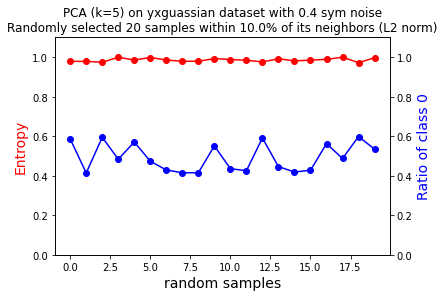

'./results/yxguassian_PCA_5_random_20_near_0.1_sym_0.4_noise.png'

In [23]:
y_axis_label_left = "Entropy"
y_axis_label_right = "Ratio of class 0"
title = "PCA (k="+str(k)+") on "+args.dataset+" dataset"+" with "+str(args.flip_rate_fixed)+" "+str(args.noise_type)+" noise"+'\n' + "Randomly selected "+str(iteration_number)+" samples within "+str(perc_closest*100)+"% of its neighbors (L2 norm)"

# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(df.index,
        df.entropy,
        color="red", 
        marker="o")
# set x-axis label
ax.set_xlabel("random samples", fontsize = 14)
# set y-axis label
ax.set_ylabel(y_axis_label_left,
              color="red",
              fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(df.index, df.class0_ratio,color="blue",marker="o")
ax2.set_ylabel(y_axis_label_right,color="blue",fontsize=14)

ax.set_ylim(0,1.1)
ax2.set_ylim(0,1.1)
plt.title (title)
plt.show()

# save the plot as a file

output_path = "./results/"+str(args.dataset)+"_PCA_"+str(args.pca_k)+"_random_"+str(args.sample_size)+"_near_"+str(perc_closest)+"_"+str(args.noise_type)+"_"+str(args.flip_rate_fixed)+"_noise"+".png"
fig.savefig(output_path,
            format='jpeg',
            dpi=100,
            bbox_inches='tight')
            
output_path


In [41]:
from inspect import Parameter
import csv
import time
df['entropy'].var()
df['class0_ratio'].var()

# create csv file
output_filename = "./results/pca_results.csv"
# with open(output_path, 'a', newline = '') as file:
#     writer = csv.writer(file)
#     writer.writerow(["dataset", "pca_k", "sample_size", "near_percentage", "noise_type", "flip_rate_fixed", "entropy_mean","entropy_variance", "ratio_mean", "ratio_variance"])

In [ ]:
k = args.pca_k

# write to each column of csv file


with open(output_path, 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([args.dataset,args.pca_k, args.sample_size, perc_closest, args.noise_type, args.flip_rate_fixed, df['entropy'].mean(), df['entropy'].var(), df['class0_ratio'].mean(), df['class0_ratio'].var()])



In [38]:
closest_index[1:10]


array([10233, 11531,  2060, 16039,  8626, 13308, 17379, 17177, 19088])

In [ ]:

# calculate l2 norm between the sample and all other samples
import numpy as np

# calculate the top 10 closest samples
top10 = np.argsort(l2_norm)[:10]
print(top10)

# calculate entropy with the top 10 closest samples
import collections
import math
def entropy(labels):
    freqdist = collections.Counter(labels)
    probs = [freqdist[label] / len(labels) for label in freqdist]
    return -sum(p * math.log(p, 2) for p in probs)

print(entropy(train_dataset.dataset.targets[top10]))

In [11]:
len(l2_norm)

20000

In [12]:
# PCA to 1D
pca1 = runPCA(train_dataset.dataset,1)
X1d=pca1.transform(train_dataset.dataset.data)

No handles with labels found to put in legend.


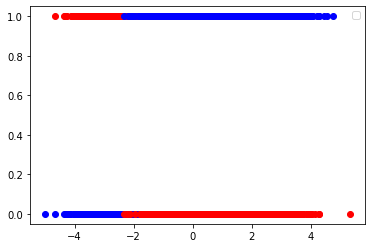

In [13]:
# visulize X 1D
# color indicate true label
scatter_x = X1d[:,0]
scatter_y = train_dataset.dataset.targets
clean_label = train_dataset.dataset.clean_targets
cdict = {0:'red',1:'blue'} # correct label : blue, incorrect label : red

fig, ax = plt.subplots()
for i in range(len(scatter_x)):
    if scatter_y[i]==clean_label[i]:
        ax.scatter(scatter_x[i],scatter_y[i], c=cdict[1], marker='o')
    else:
        ax.scatter(scatter_x[i],scatter_y[i],c=cdict[0], marker='o')
ax.legend()
plt.show()

In [110]:
import collections
import pandas as pd
#collections.Counter(train_dataset.dataset.targets == train_dataset.dataset.clean_targets)

df=pd.concat([pd.DataFrame(X1d),pd.DataFrame(train_dataset.dataset.targets),pd.DataFrame(train_dataset.dataset.clean_targets)],axis=1)
df.columns=['x1d','noise_y','clean_y']
df.sort_values(by=['x1d'],inplace=True)
df['correct'] = df['noise_y']==df['clean_y']

df['correct'].value_counts()


True     11966
False     8034
Name: correct, dtype: int64

In [ ]:

window = 1
start = int(df['x1d'].min())
end = int(df['x1d'].max())



def get_error_rate(df,window,start,end):
    ratio = []
    i=start
    while(i<end):
        class1 = len(df.loc[(df['x1d']>=i) & (df['x1d']<i+window) & (df['noise_y']==1)])
        class0 = len(df.loc[(df['x1d']>=i) & (df['x1d']<i+window) & (df['noise_y']==0)])
        
        ratio.append(class1/(class1+class0))
        #error_rate.append( (df.loc[(df['x1d']>=i) & (df['x1d']<i+window),'correct'].value_counts()[0])/(df.loc[(df['x1d']>=i) & (df['x1d']<i+window),'correct'].value_counts().sum()) )
        i+=window
    return ratio



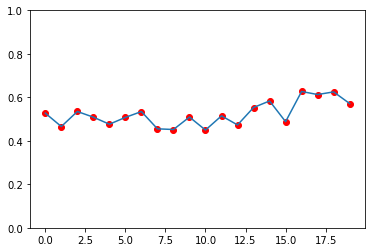

In [ ]:
window=(end-start)/20
df_res = pd.DataFrame(get_error_rate(df,window,start,end))
plt.plot(df_res)
plt.scatter(df_res.index,df_res[0],c='red')
plt.ylim(0,1)
plt.show()
